In [6]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

In [7]:
#tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

semesters = pd.read_csv('terminsstatus_17.txt', sep = '\t')
semesters.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr
0,E,1,0,20002,20002,15,-7,6.0,15,1
1,W,2,1,20112,20112,37,-7,15.0,37,1
2,D,3,1,20032,20032,21,-7,16.5,21,1
3,N,4,1,20112,20112,37,-7,30.0,37,1
4,W,5,1,20112,20112,37,-7,0.0,37,1


In [8]:
delay_one_term = lambda x: x.shift(+1)
prev_semesters = semesters.apply(delay_one_term)
mean_points = semesters.poang_p.mean()

prev = []
for i,s in enumerate(semesters.lopnr):
    if s == prev_semesters.at[i,'lopnr']:
        prev.append(prev_semesters.at[i, 'poang_p'])
    else:
        prev.append(mean_points)
prev_points_pd = pd.DataFrame(prev)
semesters['prev_points'] = prev_points_pd

In [9]:
lopnr_prev = 0
points_first_semester = []
for i, s in enumerate(semesters.lopnr):
    if s != lopnr_prev:
        p = semesters.at[i, 'poang_p']
        points_first_semester.append(p)
    else:
        points_first_semester.append(p)
    lopnr_prev = s
pfs_pd = pd.DataFrame(points_first_semester)
semesters['points_first_semester'] = pfs_pd

In [10]:
lopnr_prev = 0
acc_points = []
for i, p in enumerate(semesters.lopnr):
    if p != lopnr_prev:
        acc_points.append(semesters.at[i,'poang_p'])
    else:
        acc_points.append(acc_points[i-1] + semesters.at[i,'poang_p'])
    lopnr_prev = p
acc_points_pd = pd.DataFrame(acc_points)
#acc_points_pd.head(20)
semesters['accumulated_points'] = acc_points_pd

In [12]:
pd.options.display.max_rows = 40
lopnr_prev = 0
zero_semesters = [0]*semesters.shape[0]
for i, s in enumerate(semesters.lopnr):
    if semesters.at[i,'poang_p'] == 0:
        if s != lopnr_prev:
            zero_semesters[i] += 1
        else:
            zero_semesters[i] = zero_semesters[i-1]+1
        lopnr_prev = s
zs_pd = pd.DataFrame(zero_semesters)
semesters['zero_semesters'] = zs_pd
semesters.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,prev_points,points_first_semester,accumulated_points,zero_semesters
0,E,1,0,20002,20002,15,-7,6.0,15,1,16.1,6.0,6.0,0
1,W,2,1,20112,20112,37,-7,15.0,37,1,16.1,15.0,15.0,0
2,D,3,1,20032,20032,21,-7,16.5,21,1,16.1,16.5,16.5,0
3,N,4,1,20112,20112,37,-7,30.0,37,1,16.1,30.0,30.0,0
4,W,5,1,20112,20112,37,-7,0.0,37,1,16.1,0.0,0.0,1


# Välj vilka features vi vill ha

In [13]:
x = semesters.iloc[:, 10:].values
y = semesters.iloc[:, 8].values
x

array([[16.11571366,  6.        ,  6.        ,  0.        ],
       [16.11571366, 15.        , 15.        ,  0.        ],
       [16.11571366, 16.5       , 16.5       ,  0.        ],
       ...,
       [16.11571366, 12.        , 12.        ,  0.        ],
       [16.11571366,  0.        ,  0.        ,  1.        ],
       [16.11571366,  0.        ,  0.        ,  1.        ]])

# Encoda string-variables (när de används)

In [15]:
# kod för det här

# Dela upp i träning och test

In [14]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# Scalea numeriska värden

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Building the NN

In [19]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

In [16]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [48]:
# create model
from keras.layers import Dropout
from keras.layers import LSTM
model = Sequential()
model.add(Dense(16, input_dim=4, kernel_initializer='normal', 
                activation='relu'))
model.add(Dense(64, input_dim=4, kernel_initializer='normal', 
                activation='relu'))

#model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model

model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mse'])

history = model.fit(X_train,y_train,epochs=10, batch_size=128)


Epoch 1/10
197382/197382 [==============================] - 5s 27us/step - loss: 143.1779 - mean_squared_error: 143.1779
Epoch 2/10
197382/197382 [==============================] - 4s 20us/step - loss: 110.4084 - mean_squared_error: 110.4084
Epoch 3/10
197382/197382 [==============================] - 4s 23us/step - loss: 109.7195 - mean_squared_error: 109.7195
Epoch 4/10
197382/197382 [==============================] - 4s 22us/step - loss: 109.0776 - mean_squared_error: 109.0776
Epoch 5/10
197382/197382 [==============================] - 4s 21us/step - loss: 108.4879 - mean_squared_error: 108.4879
Epoch 6/10
197382/197382 [==============================] - 4s 22us/step - loss: 107.9906 - mean_squared_error: 107.9906
Epoch 7/10
197382/197382 [==============================] - 6s 29us/step - loss: 107.6060 - mean_squared_error: 107.6060
Epoch 8/10
197382/197382 [==============================] - 4s 22us/step - loss: 107.2875 - mean_squared_error: 107.2875 1s - loss: 107
Epoch 9/10
197382

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 13)                65        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 14        
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


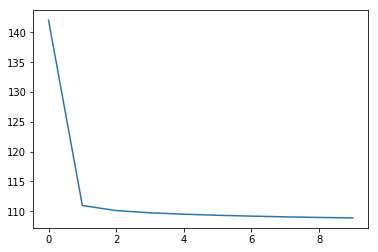

In [33]:
import matplotlib.pyplot as plt

loss = history.history['loss']
num_epochs = np.arange(10)
plt.plot(num_epochs, loss)
plt.show()

In [29]:
history.history

{'loss': [142.05504549734243,
  110.97041164465102,
  110.1142622766053,
  109.73852535661041,
  109.50486859656725,
  109.3284510358451,
  109.18246994979467,
  109.06052819952299,
  108.96160725776791,
  108.88278968572082],
 'mean_squared_error': [142.05504549734243,
  110.97041164465102,
  110.1142622766053,
  109.73852535661041,
  109.50486859656725,
  109.3284510358451,
  109.18246994979467,
  109.06052819952299,
  108.96160725776791,
  108.88278968572082]}

KeyboardInterrupt: 